<a href="https://colab.research.google.com/github/SaeidBrz/water-scarcity-forecasting/blob/main/LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
########################################
# 1) IMPORT LIBRARIES & MOUNT DRIVE
########################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')  # Mount your Google Drive

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from collections import defaultdict

########################################
# 2) LOAD DATA
########################################
file_path = '/content/drive/My Drive/merged_cleaned_10_20.csv'
original_df = pd.read_csv(file_path)

# Check the data types again.
print(original_df.info())

########################################
# 3) DATA EXPLORATION (Basic Checks)
########################################
print("\nData Preview:")
print(original_df.head(50))

print("\nDataset Information:")
print(original_df.info())

print(f"\nShape: {original_df.shape}")
print("\nMissing Values:")
print(original_df.isnull().sum()[original_df.isnull().sum() > 0])
print("\nStatistical Summary:")
print(original_df.describe())

# Count values greater than or equal to 1 for each column
greater_than_one_counts = (original_df >= 1).sum()
print("\nNumber of values >= 1 per column:")
print(greater_than_one_counts)

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63431 entries, 0 to 63430
Data columns (total 50 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lon               63431 non-null  float64
 1   lat               63431 non-null  float64
 2   wd_01             63431 non-null  float64
 3   wd_02             63431 non-null  float64
 4   wd_03             63431 non-null  float64
 5   wd_04             63431 non-null  float64
 6   wd_05             63431 non-null  float64
 7   wd_06             63431 non-null  float64
 8   wd_07             63431 non-null  float64
 9   wd_08             63431 non-null  float64
 10  wd_09             63431 non-null  float64
 11  wd_10             63431 non-null  float64
 12  wd_11             63431 non-null  float64
 13  wd_12             63431 non-null  float64
 14  precipitation_01  63431 non-null  float64
 15  precipitation_02  63431 non-null  float64
 16  precipitation_

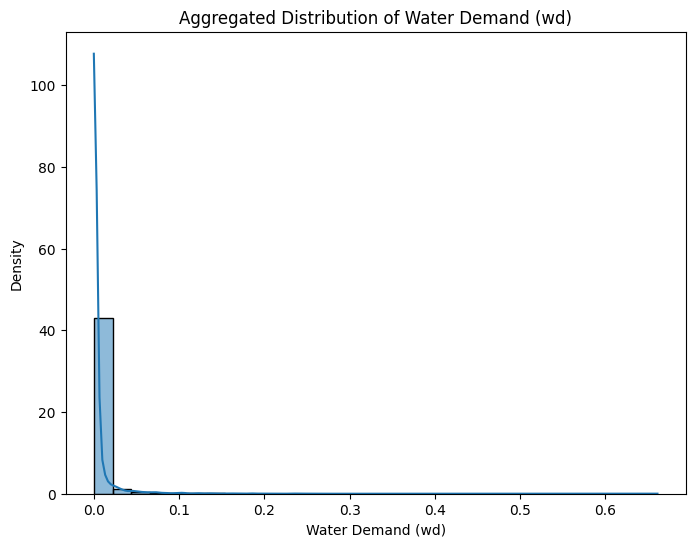

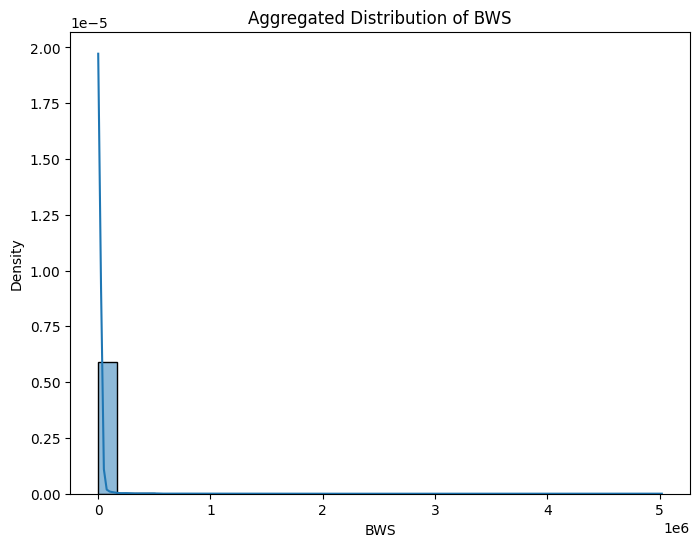

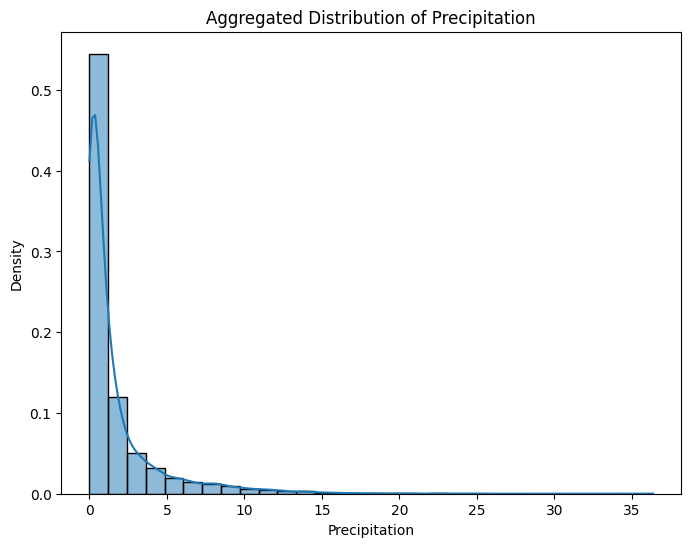

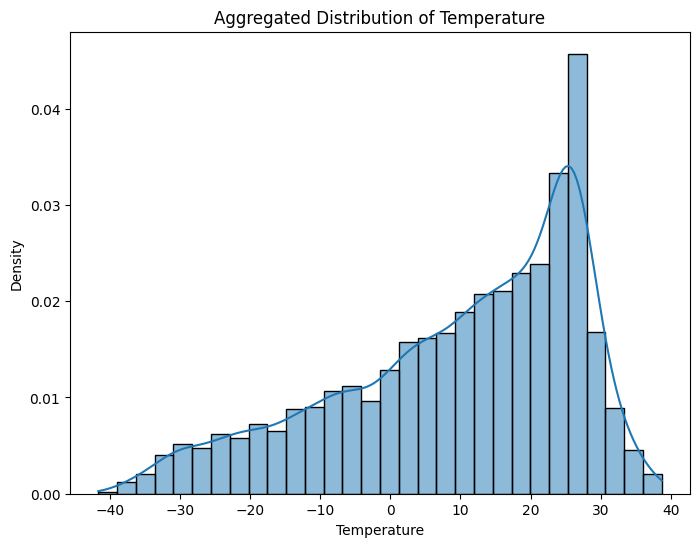

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Identify the column groups based on naming conventions.
wd_cols = [col for col in original_df.columns if col.startswith("wd_")]
bws_cols = [col for col in original_df.columns if col.startswith("bws_")]
precip_cols = [col for col in original_df.columns if col.startswith("precipitation_")]
temp_cols = [col for col in original_df.columns if col.startswith("Temperature")]

def plot_aggregated_distribution(df, columns, var_label, sample_size=10000, kde=True, bins=30):
    """
    Aggregates the values from multiple columns into a single Series and plots their distribution.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        columns (list): List of column names to aggregate.
        var_label (str): A label for the variable (used for plot titles and labels).
        sample_size (int): Maximum number of points to plot. If the aggregated data has more
                           than this number, a random sample will be used. Set to None to use all data.
        kde (bool): Whether to overlay a kernel density estimate.
        bins (int): Number of histogram bins.
    """
    # Concatenate values from the specified columns into one Series and drop missing values.
    aggregated_series = pd.concat([df[col] for col in columns], ignore_index=True).dropna()

    # Sample data if the series is too large.
    if sample_size is not None and len(aggregated_series) > sample_size:
        aggregated_series = aggregated_series.sample(sample_size, random_state=42)

    plt.figure(figsize=(8, 6))
    sns.histplot(aggregated_series, kde=kde, bins=bins, stat="density")  # Changed stat to density
    plt.title(f'Aggregated Distribution of {var_label}')
    plt.xlabel(var_label)
    plt.ylabel('Density')  # Updated y-axis label
    plt.show()

# Plot the aggregated distributions.
plot_aggregated_distribution(original_df, wd_cols, "Water Demand (wd)")
plot_aggregated_distribution(original_df, bws_cols, "BWS")
plot_aggregated_distribution(original_df, precip_cols, "Precipitation")
plot_aggregated_distribution(original_df, temp_cols, "Temperature")

In [ ]:
########################################
# 4) BUILD FEATURES/TARGETS WITH GROUP ID AND SEASON AS NUMBER
########################################

# Define a function to assign season as a number directly.
def assign_season(month, lat):
    """
    Assign a season number given a month (1-12) and latitude.
    Northern Hemisphere:
      - Winter: months [12, 1, 2] -> 1
      - Spring: months [3, 4, 5]  -> 2
      - Summer: months [6, 7, 8]  -> 3
      - Autumn: months [9, 10, 11]-> 4
    Southern Hemisphere (shifted):
      - Months [12, 1, 2] are Summer -> 3
      - Months [3, 4, 5] are Autumn  -> 4
      - Months [6, 7, 8] are Winter  -> 1
      - Months [9, 10, 11] are Spring -> 2
    """
    if lat >= 0:  # Northern Hemisphere
        if month in [12, 1, 2]:
            return 1   # Winter
        elif month in [3, 4, 5]:
            return 2   # Spring
        elif month in [6, 7, 8]:
            return 3   # Summer
        elif month in [9, 10, 11]:
            return 4   # Autumn
    else:  # Southern Hemisphere
        if month in [12, 1, 2]:
            return 3   # Summer
        elif month in [3, 4, 5]:
            return 4   # Autumn
        elif month in [6, 7, 8]:
            return 1   # Winter
        elif month in [9, 10, 11]:
            return 2   # Spring
########################################
# 4) BUILD FEATURES/TARGETS WITH GROUP ID AND SEASON AS NUMBER
########################################

# Initialize empty DataFrames for features and target.
features_df = pd.DataFrame()
target_df = pd.DataFrame()

# Loop over months 1–12 to build the dataset.
for month in range(1, 13):
    # Define column names for each category.
    bws_col  = f"bws_{month:02}"
    wd_col   = f"wd_{month:02}"
    precip_col = f"precipitation_{month:02}"
    temp_col   = f"Temperature{month:02}"  # Matches e.g., "Temperature01", "Temperature02", etc.

    # Check that all required columns exist.
    if (bws_col in original_df.columns and
        wd_col in original_df.columns and
        precip_col in original_df.columns and
        temp_col in original_df.columns):

        # Use original lon/lat and add a group id based on the original row index.
        temp_features = original_df[['lon', 'lat']].copy()
        temp_features['month'] = month
        temp_features['wd'] = original_df[wd_col]
        temp_features['precipitation'] = original_df[precip_col]
        temp_features['temperature'] = original_df[temp_col]
        # Compute season using the helper function.
        temp_features['season'] = temp_features.apply(lambda row: assign_season(month, row['lat']), axis=1)
        # Add a 'group' column (e.g., original row index) to keep together observations from the same location.
        temp_features['group'] = original_df.index

        # Extract target variable.
        temp_target = original_df[bws_col]

        # Append to the master DataFrames.
        features_df = pd.concat([features_df, temp_features], ignore_index=True)
        target_df = pd.concat([target_df, temp_target], ignore_index=True)
    else:
        print(f"Missing data for month {month:02}. Skipping this month.")

# Rename target column.
target_df.columns = ['bws']

print("\nFeatures DataFrame (sample):")
print(features_df.head(25))
print("\nTarget DataFrame (sample):")
print(target_df.head(25))
########################################
# 5) ENCODE MONTH AS CYCLICAL FEATURES
########################################
# Create cyclical features for the month.
features_df['month_sin'] = np.sin(2 * np.pi * features_df['month'] / 12)
features_df['month_cos'] = np.cos(2 * np.pi * features_df['month'] / 12)
# Drop the raw month column.
features_df.drop(columns=['month'], inplace=True)

print("\nFeatures DataFrame after adding cyclical month features:")
print(features_df.head(25))


########################################
# 6) 3D CARTESIAN COORDINATES TRANSFORMATION
########################################
if 'lon' in features_df.columns and 'lat' in features_df.columns:
    # Convert latitude and longitude to radians.
    features_df['lat_rad'] = np.radians(features_df['lat'])
    features_df['lon_rad'] = np.radians(features_df['lon'])
    # Compute Cartesian coordinates.
    features_df['x'] = np.cos(features_df['lat_rad']) * np.cos(features_df['lon_rad'])
    features_df['y'] = np.cos(features_df['lat_rad']) * np.sin(features_df['lon_rad'])
    features_df['z'] = np.sin(features_df['lat_rad'])
    # Drop original and intermediate radian columns.
    features_df.drop(columns=['lon', 'lat', 'lat_rad', 'lon_rad'], inplace=True)
else:
    print("Error: 'lon' and 'lat' columns are missing in features_df.")

# Create additional interaction features among spatial coordinates.
features_df["x_y"] = features_df["x"] * features_df["y"]
features_df["x_z"] = features_df["x"] * features_df["z"]
features_df["y_z"] = features_df["y"] * features_df["z"]

# --- Interaction features for wind (wd) ---
features_df["wd_x"] = features_df["wd"] * features_df["x"]
features_df["wd_y"] = features_df["wd"] * features_df["y"]
features_df["wd_z"] = features_df["wd"] * features_df["z"]
features_df["wd_season"] = features_df["wd"] * features_df["season"]
features_df["wd_month_sin"] = features_df["wd"] * features_df["month_sin"]
features_df["wd_month_cos"] = features_df["wd"] * features_df["month_cos"]

# --- Interaction features for precipitation ---
features_df["precipitation_x"] = features_df["precipitation"] * features_df["x"]
features_df["precipitation_y"] = features_df["precipitation"] * features_df["y"]
features_df["precipitation_z"] = features_df["precipitation"] * features_df["z"]
features_df["precipitation_season"] = features_df["precipitation"] * features_df["season"]
features_df["precipitation_month_sin"] = features_df["precipitation"] * features_df["month_sin"]
features_df["precipitation_month_cos"] = features_df["precipitation"] * features_df["month_cos"]

# --- Interaction features for temperature ---
features_df["temperature_x"] = features_df["temperature"] * features_df["x"]
features_df["temperature_y"] = features_df["temperature"] * features_df["y"]
features_df["temperature_z"] = features_df["temperature"] * features_df["z"]
features_df["temperature_season"] = features_df["temperature"] * features_df["season"]
features_df["temperature_month_sin"] = features_df["temperature"] * features_df["month_sin"]
features_df["temperature_month_cos"] = features_df["temperature"] * features_df["month_cos"]

print("\nFeatures DataFrame after 3D Cartesian transformation and adding interactions (sample):")
print(features_df.head(30))
print("\nShape of features_df:", features_df.shape)

########################################
# 7) GROUP-BASED TRAIN, VALIDATION & TEST SPLIT
########################################
# Combine features and target into a single DataFrame.
merged_df = features_df.copy()
merged_df['bws'] = target_df['bws']

print("\nMerged DataFrame shape:", merged_df.shape)

# --- First Split: Train+Validation (80%) and Test (20%) using GroupShuffleSplit ---
gss = GroupShuffleSplit(test_size=0.2, random_state=42)
groups = merged_df['group']
train_val_idx, test_idx = next(gss.split(merged_df, groups=groups))
train_val_data = merged_df.iloc[train_val_idx].copy()
test_data = merged_df.iloc[test_idx].copy()

print("\nAfter first group-based split:")
print("Train+Validation shape:", train_val_data.shape)
print("Test shape:", test_data.shape)

# --- Second Split: Split Train+Validation into Training (60%) and Validation (20%) ---
gss_val = GroupShuffleSplit(test_size=0.25, random_state=42)  # 0.25 of train_val will be validation.
groups_train_val = train_val_data['group']
train_idx, val_idx = next(gss_val.split(train_val_data, groups=groups_train_val))
train_data = train_val_data.iloc[train_idx].copy()
val_data = train_val_data.iloc[val_idx].copy()

print("\nAfter second group-based split:")
print("Training shape:", train_data.shape)
print("Validation shape:", val_data.shape)

# --- Separate Features and Target ---
# Drop columns that should not be used for training.
X_train = train_data.drop(['bws', 'group'], axis=1)
y_train = train_data['bws']

X_val = val_data.drop(['bws', 'group'], axis=1)
y_val = val_data['bws']

X_test = test_data.drop(['bws', 'group'], axis=1)
y_test = test_data['bws']

print("\nFinal dataset shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


##############################################
# 8) TRAIN LIGHTGBM WITH CALLBACKS (With History)
##############################################
from lightgbm import LGBMRegressor

model = LGBMRegressor(
    learning_rate=0.01,  # Slightly higher for faster convergence
    n_estimators=50000,  # Reduce unnecessary rounds
    num_leaves=80,  # Reduce complexity (prevent overfitting)
    max_depth=16,  # Limit tree depth
    subsample=0.85,  # Keep 80% of data in each tree
    colsample_bytree= 0.8,  # Feature sampling
    reg_alpha= 0.9,  # Increase L1 regularization
    reg_lambda= 0.8,  # Increase L2 regularization
    min_child_samples=20,  # Require more samples per leaf
    random_state=42,
)

# Dictionary to store evaluation results.
evals_result = defaultdict(list)

# Custom callback to record evaluation results.
def record_evaluation_result(env):
    for data_name, eval_name, result, _ in env.evaluation_result_list:
        evals_result[f"{data_name}_{eval_name}"].append(result)

# Train the model.
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric='rmse',
    callbacks=[
        early_stopping(stopping_rounds=500, verbose=True),
        log_evaluation(period=100),
        record_evaluation_result
    ]
)

print("\nEvaluation history (first few entries):")
for key, values in evals_result.items():
    print(f"{key}: {values[:5]} ...")

########################################
# 9) EVALUATE MODEL PERFORMANCE ON TEST DATA
########################################
# Predict on the test set.
if hasattr(model, "best_iteration_") and model.best_iteration_ is not None:
    y_test_pred = model.predict(X_test, num_iteration=model.best_iteration_)
else:
    y_test_pred = model.predict(X_test)

y_test = np.array(y_test).ravel()
y_test_pred = np.array(y_test_pred).ravel()

# Calculate metrics.
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
var_y_test = np.var(y_test) if np.var(y_test) != 0 else np.nan
nmse = mse / var_y_test
denom_nse = np.sum((y_test - np.mean(y_test)) ** 2)
nse = 1 - (np.sum((y_test - y_test_pred) ** 2) / denom_nse) if denom_nse != 0 else np.nan
sum_y_test = np.sum(y_test)
pbias = 100 * np.sum(y_test - y_test_pred) / sum_y_test if sum_y_test != 0 else np.nan

metrics_df = pd.DataFrame({
    "Metric": [
        "Mean Squared Error (MSE)",
        "Root Mean Squared Error (RMSE)",
        "Mean Absolute Error (MAE)",
        "R-squared (R²)",
        "Normalized MSE (NMSE)",
        "Nash-Sutcliffe Efficiency (NSE)",
        "Percent Bias (PBIAS)"
    ],
    "Value": [mse, rmse, mae, r2, nmse, nse, pbias]
})

print("\n✅ Model Performance on Test Set:")
print(metrics_df)



Features DataFrame (sample):
       lon    lat  month        wd  precipitation  temperature  season  group
0  -179.25  66.25      1  0.000003       0.571275   -19.714524       1      0
1  -179.25  66.75      1  0.000004       0.563261   -22.760843       1      1
2  -179.25  67.25      1  0.000004       0.535378   -24.208890       1      2
3  -179.25  67.75      1  0.000004       0.441522   -24.602039       1      3
4  -179.25  68.25      1  0.000004       0.346070   -23.604781       1      4
5  -179.25  68.75      1  0.000003       0.291187   -22.301417       1      5
6  -179.25  71.25      1  0.000003       0.111327   -23.239421       1      6
7  -178.75  66.25      1  0.000003       0.570050   -19.440483       1      7
8  -178.75  66.75      1  0.000004       0.545590   -22.568871       1      8
9  -178.75  67.25      1  0.000004       0.488480   -24.154234       1      9
10 -178.75  67.75      1  0.000004       0.374234   -24.150012       1     10
11 -178.75  68.25      1  0.000004

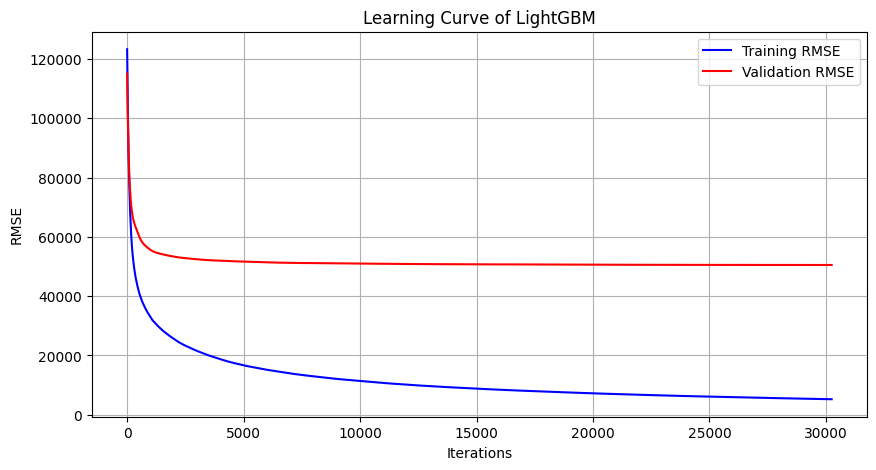

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Extract correct RMSE lists
train_rmse = evals_result['training_rmse']  # or evals_result['training rmse']
valid_rmse = evals_result['valid_1_rmse']  # or evals_result['valid_1 rmse']

# Plot RMSE over iterations
plt.plot(range(len(train_rmse)), train_rmse, label='Training RMSE', color='blue')
plt.plot(range(len(valid_rmse)), valid_rmse, label='Validation RMSE', color='red')

plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.title("Learning Curve of LightGBM")
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-7-bc06807d591b>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


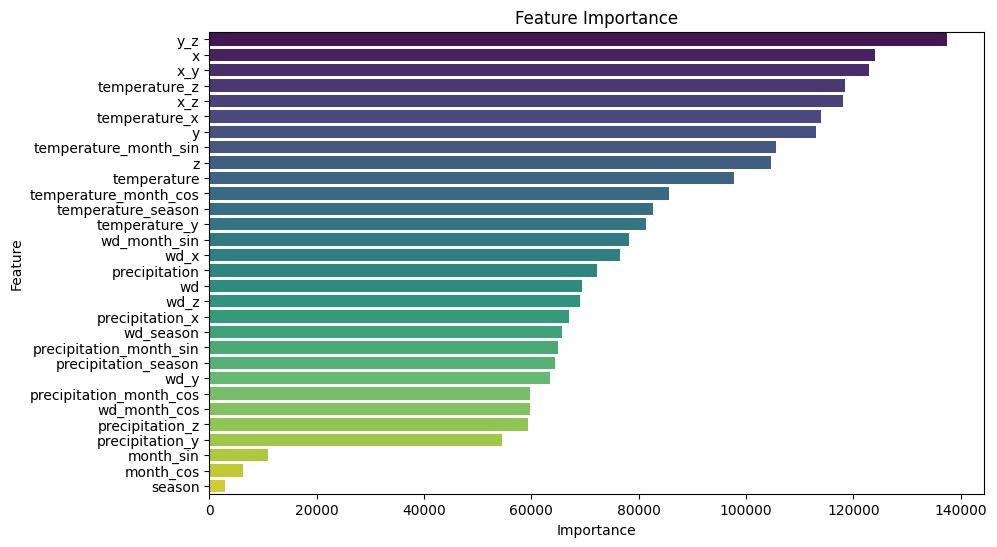

In [ ]:
########################################
# 10) OPTIONAL PLOTTING & FEATURE ANALYSIS
########################################
# Feature importance
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


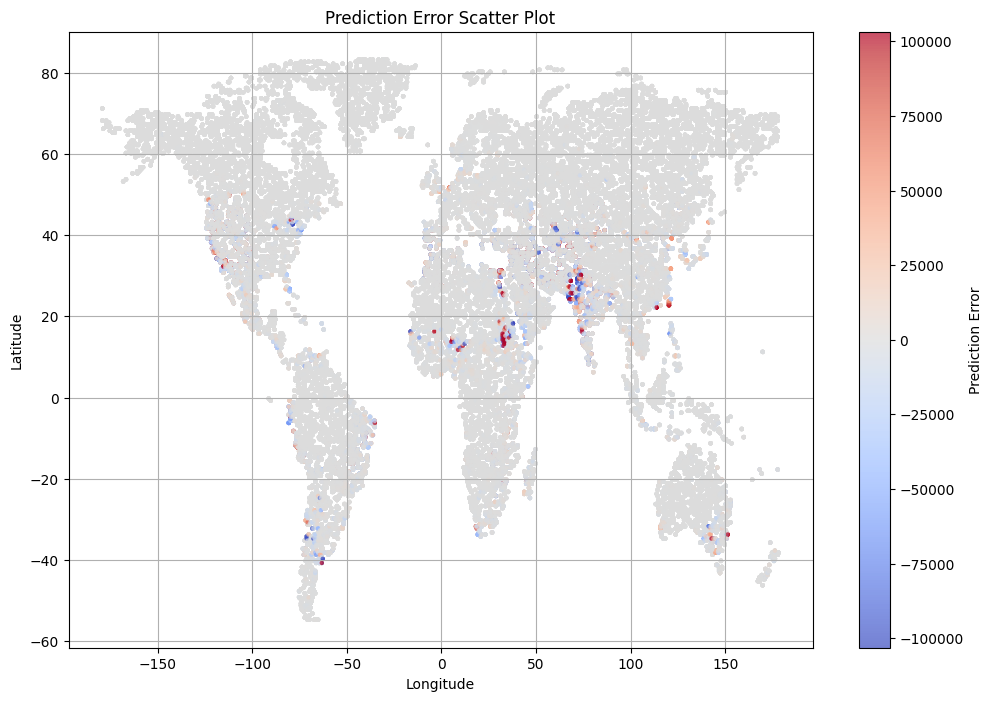

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Compute RMSE for visualization scale
rmse = np.sqrt(np.mean((y_test - y_test_pred) ** 2))

# Reconstruct approximate coordinates for error analysis
X_test_with_coords = X_test.copy()
X_test_with_coords['lat'] = np.degrees(np.arcsin(X_test_with_coords['z']))
X_test_with_coords['lon'] = np.degrees(np.arctan2(X_test_with_coords['y'], X_test_with_coords['x']))

# Create error dataframe
error_df = pd.DataFrame({
    'lat': X_test_with_coords['lat'],
    'lon': X_test_with_coords['lon'],
    'error': y_test - y_test_pred
})

# Create a centered norm with vmin and vmax
norm = colors.CenteredNorm(vcenter=0, halfrange=rmse * 2)  # Automatically scales color around 0

# Create plot
plt.figure(figsize=(12, 8))
sc = plt.scatter(
    error_df['lon'], error_df['lat'], c=error_df['error'], cmap='coolwarm',
    norm=norm,  # Use norm to scale colors properly
    alpha=0.7, edgecolors='none', s=10  # Adjust size and transparency
)

# Add color bar and labels
plt.colorbar(sc, label="Prediction Error")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Prediction Error Scatter Plot")
plt.grid(True)
plt.show()

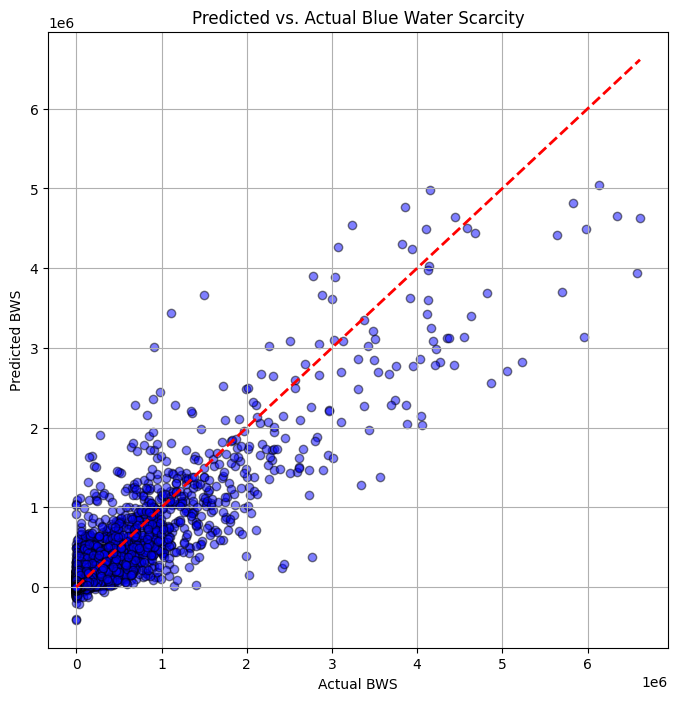

In [ ]:
import numpy as np

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_test_pred, alpha=0.5, color="blue", edgecolors="k")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle="dashed", linewidth=2)
plt.xlabel("Actual BWS")
plt.ylabel("Predicted BWS")
plt.title("Predicted vs. Actual Blue Water Scarcity")
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

# -------------------------------
# Helper: Season Assignment Function
# -------------------------------
def assign_season(month, lat):
    if lat >= 0:  # Northern Hemisphere
        if month in [12, 1, 2]:
            return 1
        elif month in [3, 4, 5]:
            return 2
        elif month in [6, 7, 8]:
            return 3
        elif month in [9, 10, 11]:
            return 4
    else:  # Southern Hemisphere
        if month in [12, 1, 2]:
            return 3
        elif month in [3, 4, 5]:
            return 4
        elif month in [6, 7, 8]:
            return 1
        elif month in [9, 10, 11]:
            return 2

# =============================================================================
# PART 1: PREDICTION ON NEW CSV FILE AND SAVING RESULTS
# =============================================================================

# 1. Load new CSV file with features.
new_file_path = '/content/drive/My Drive/merged_cleaned_41_60.csv'
new_df = pd.read_csv(new_file_path)
print("Columns in CSV:", new_df.columns.tolist())

# 2. Reconstruct the features exactly as in training.
# We'll also store meta information (lon, lat, month) for the final CSV.
features_list = []
meta_list = []

for month in range(1, 13):
    wd_col     = f"wd_{month:02}"             # e.g., wd_01, wd_02, ...
    temp_col   = f"Temperature_{month:02}"      # e.g., Temperature_01, Temperature_02, ...
    precip_col = f"Precipitation_{month:02}"     # e.g., Precipitation_01, Precipitation_02, ...

    # Check that all required columns are present.
    if wd_col in new_df.columns and temp_col in new_df.columns and precip_col in new_df.columns:
        # Use lon & lat for both feature processing and meta information.
        temp_features = new_df[['lon', 'lat']].copy()
        temp_features['month'] = month
        temp_features['wd'] = new_df[wd_col]
        temp_features['temperature'] = new_df[temp_col]
        temp_features['precipitation'] = new_df[precip_col]
        temp_features['season'] = temp_features.apply(lambda row: assign_season(month, row['lat']), axis=1)

        # Save meta info for final output (lon, lat, and month).
        meta_list.append(new_df[['lon', 'lat']].copy())
        features_list.append(temp_features)
    else:
        print(f"Missing data for month {month:02}. Skipping this month.")

if len(features_list) == 0:
    raise ValueError("No objects to concatenate. Check your CSV column names.")

# Concatenate all monthly data.
features_df_new = pd.concat(features_list, ignore_index=True)
meta_df = pd.concat(meta_list, ignore_index=True)

# 3. Encode month as cyclical features.
features_df_new['month_sin'] = np.sin(2 * np.pi * features_df_new['month'] / 12)
features_df_new['month_cos'] = np.cos(2 * np.pi * features_df_new['month'] / 12)
features_df_new.drop(columns=['month'], inplace=True)

# 4. Convert lon/lat to 3D Cartesian coordinates.
features_df_new['lat_rad'] = np.radians(features_df_new['lat'])
features_df_new['lon_rad'] = np.radians(features_df_new['lon'])
features_df_new['x'] = np.cos(features_df_new['lat_rad']) * np.cos(features_df_new['lon_rad'])
features_df_new['y'] = np.cos(features_df_new['lat_rad']) * np.sin(features_df_new['lon_rad'])
features_df_new['z'] = np.sin(features_df_new['lat_rad'])
features_df_new.drop(columns=['lon', 'lat', 'lat_rad', 'lon_rad'], inplace=True)

# 5. Create interaction features.
features_df_new["x_y"] = features_df_new["x"] * features_df_new["y"]
features_df_new["x_z"] = features_df_new["x"] * features_df_new["z"]
features_df_new["y_z"] = features_df_new["y"] * features_df_new["z"]

# Interactions for wind.
features_df_new["wd_x"] = features_df_new["wd"] * features_df_new["x"]
features_df_new["wd_y"] = features_df_new["wd"] * features_df_new["y"]
features_df_new["wd_z"] = features_df_new["wd"] * features_df_new["z"]
features_df_new["wd_season"] = features_df_new["wd"] * features_df_new["season"]
features_df_new["wd_month_sin"] = features_df_new["wd"] * features_df_new["month_sin"]
features_df_new["wd_month_cos"] = features_df_new["wd"] * features_df_new["month_cos"]

# Interactions for precipitation.
features_df_new["precipitation_x"] = features_df_new["precipitation"] * features_df_new["x"]
features_df_new["precipitation_y"] = features_df_new["precipitation"] * features_df_new["y"]
features_df_new["precipitation_z"] = features_df_new["precipitation"] * features_df_new["z"]
features_df_new["precipitation_season"] = features_df_new["precipitation"] * features_df_new["season"]
features_df_new["precipitation_month_sin"] = features_df_new["precipitation"] * features_df_new["month_sin"]
features_df_new["precipitation_month_cos"] = features_df_new["precipitation"] * features_df_new["month_cos"]

# Interactions for temperature.
features_df_new["temperature_x"] = features_df_new["temperature"] * features_df_new["x"]
features_df_new["temperature_y"] = features_df_new["temperature"] * features_df_new["y"]
features_df_new["temperature_z"] = features_df_new["temperature"] * features_df_new["z"]
features_df_new["temperature_season"] = features_df_new["temperature"] * features_df_new["season"]
features_df_new["temperature_month_sin"] = features_df_new["temperature"] * features_df_new["month_sin"]
features_df_new["temperature_month_cos"] = features_df_new["temperature"] * features_df_new["month_cos"]

# 6. Batch predictions with progress bar.
batch_size = 1000
n_samples = features_df_new.shape[0]
num_batches = int(np.ceil(n_samples / batch_size))
predictions = []

# Assuming 'loaded_model' is your pre-trained model loaded from disk.
for i in tqdm(range(num_batches), desc="Predicting batches"):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, n_samples)
    batch_X = features_df_new.iloc[start_idx:end_idx]
    if hasattr(model, "best_iteration_"):
        batch_pred = model.predict(batch_X, num_iteration= model.best_iteration_)
    else:
        batch_pred = model.predict(batch_X)
    predictions.append(batch_pred)

predictions = np.concatenate(predictions)

# 7. Combine predictions with the meta info (lon, lat) for final CSV.
meta_df = meta_df.reset_index(drop=True)
final_df = meta_df.copy()
final_df['predicted_bws'] = predictions

# 8. Optionally, if you want to know which month each prediction corresponds to, you might add that.
# For example, if you had saved 'month' in meta_df, include it here.
# final_df['month'] = ... (if available)

# 9. Save the final CSV.
output_path = '/content/drive/My Drive/predictions_new_21_40.csv'
final_df.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")

Columns in CSV: ['lon', 'lat', 'wd_01', 'wd_02', 'wd_03', 'wd_04', 'wd_05', 'wd_06', 'wd_07', 'wd_08', 'wd_09', 'wd_10', 'wd_11', 'wd_12', 'Temperature_01', 'Temperature_02', 'Temperature_03', 'Temperature_04', 'Temperature_05', 'Temperature_06', 'Temperature_07', 'Temperature_08', 'Temperature_09', 'Temperature_10', 'Temperature_11', 'Temperature_12', 'Precipitation_01', 'Precipitation_02', 'Precipitation_03', 'Precipitation_04', 'Precipitation_05', 'Precipitation_06', 'Precipitation_07', 'Precipitation_08', 'Precipitation_09', 'Precipitation_10', 'Precipitation_11', 'Precipitation_12']


Predicting batches: 100%|██████████| 722/722 [1:45:27<00:00,  8.76s/it]


Predictions saved to /content/drive/My Drive/predictions_new_21_40.csv


In [ ]:
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path to your CSV file in Google Drive
file_path = '/content/drive/My Drive/predictions_new_41_60.csv'

# Read the CSV file
df = pd.read_csv(file_path)

# Display head and tail of the DataFrame
print("Head of the dataset:")
print(df.head())

print("\nTail of the dataset:")
print(df.tail())

# Get number of rows and columns
num_rows, num_cols = df.shape
print(f"\nNumber of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

# Count NaN values per column
nan_counts = df.isna().sum()
print("\nNumber of NaN values per column:")
print(nan_counts)

# Count negative values per column
negative_counts = (df < 0).sum()
print("\nNumber of negative values per column:")
print(negative_counts)

# Get min and max values per column
min_values = df.min()
max_values = df.max()
print("\nMinimum values per column:")
print(min_values)

print("\nMaximum values per column:")
print(max_values)

# Count values greater than or equal to 1 for each column
greater_than_one_counts = (df >= 1).sum()
print("\nNumber of values >= 1 per column:")
print(greater_than_one_counts)

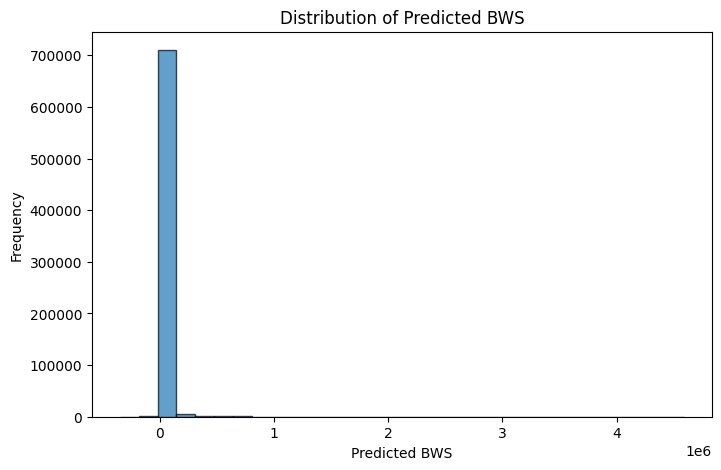

In [ ]:
import matplotlib.pyplot as plt

# Plot the distribution of 'predicted_bws'
plt.figure(figsize=(8, 5))
plt.hist(df['predicted_bws'], bins=30, edgecolor='black', alpha=0.7)

# Labels and title
plt.xlabel('Predicted BWS')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted BWS')

# Show the plot
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

📊 Comparison of Actual vs. Predicted BWS Statistics:
               Metric  Actual BWS (2010-2020)  Predicted BWS (2020-2040)
0                Mean            10521.159629               11660.303866
1              Median                0.171672                 669.732779
2  Standard Deviation           122372.310274               85497.636838


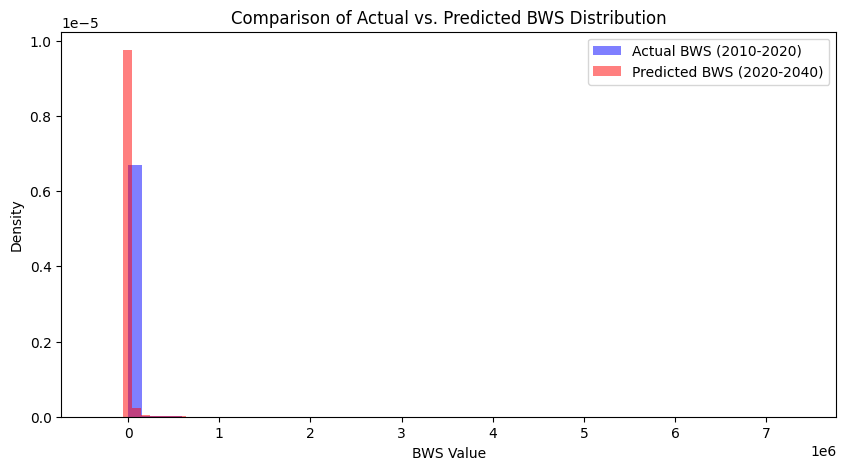

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

# 🔹 Step 1: Mount Google Drive
drive.mount('/content/drive')

# 🔹 Step 2: Define File Paths (Change these paths to match your Google Drive structure)
actual_file_path = "/content/drive/My Drive/merged_cleaned_10_20.csv"
predicted_file_path = "/content/drive/My Drive/predictions_new_21_40.csv"

# 🔹 Step 3: Load the Datasets
df_actual = pd.read_csv(actual_file_path)
df_predicted = pd.read_csv(predicted_file_path)

# 🔹 Step 4: Extract BWS Values
actual_bws_values = df_actual[[col for col in df_actual.columns if 'bws_' in col]].values.flatten()
predicted_bws_values = df_predicted["predicted_bws"].values

# 🔹 Step 5: Compute Basic Statistics
bws_comparison_stats = pd.DataFrame({
    "Metric": ["Mean", "Median", "Standard Deviation"],
    "Actual BWS (2010-2020)": [
        np.mean(actual_bws_values),
        np.median(actual_bws_values),
        np.std(actual_bws_values)
    ],
    "Predicted BWS (2020-2040)": [
        np.mean(predicted_bws_values),
        np.median(predicted_bws_values),
        np.std(predicted_bws_values)
    ]
})

# 🔹 Step 6: Display Comparison Table
print("\n📊 Comparison of Actual vs. Predicted BWS Statistics:")
print(bws_comparison_stats)

# 🔹 Step 7: Plot Distribution for Visual Comparison
plt.figure(figsize=(10, 5))
plt.hist(actual_bws_values, bins=50, alpha=0.5, label="Actual BWS (2010-2020)", color='blue', density=True)
plt.hist(predicted_bws_values, bins=50, alpha=0.5, label="Predicted BWS (2020-2040)", color='red', density=True)
plt.xlabel("BWS Value")
plt.ylabel("Density")
plt.title("Comparison of Actual vs. Predicted BWS Distribution")
plt.legend()
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


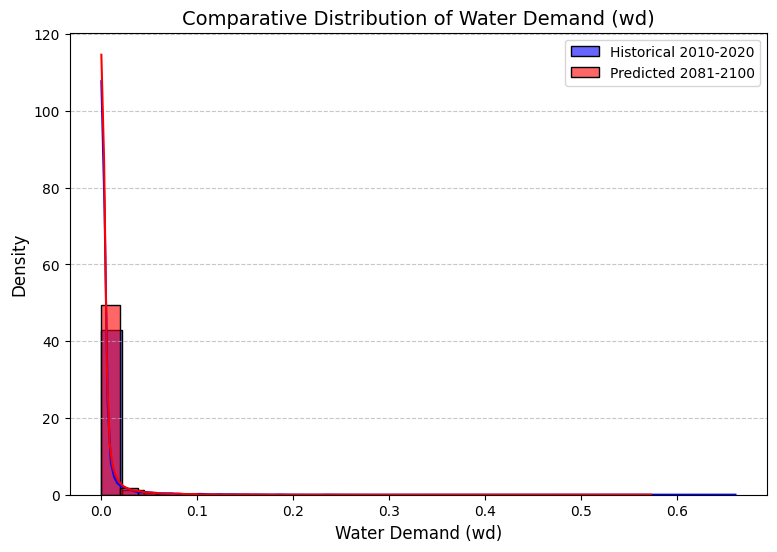

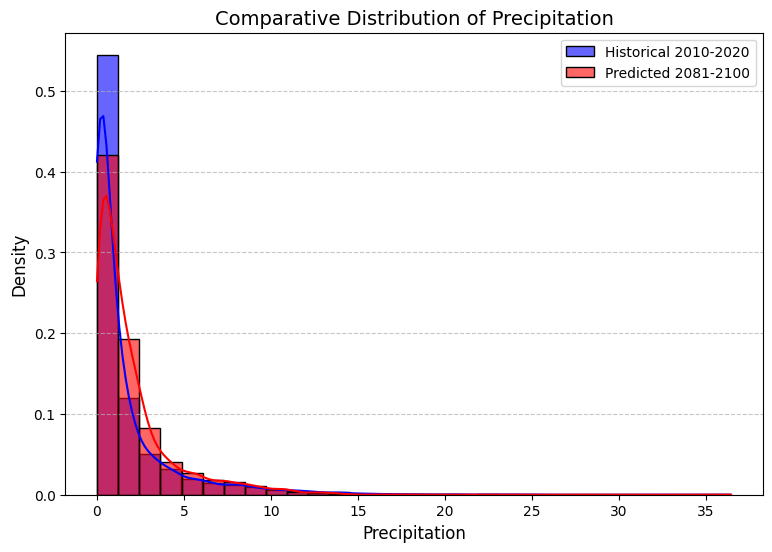

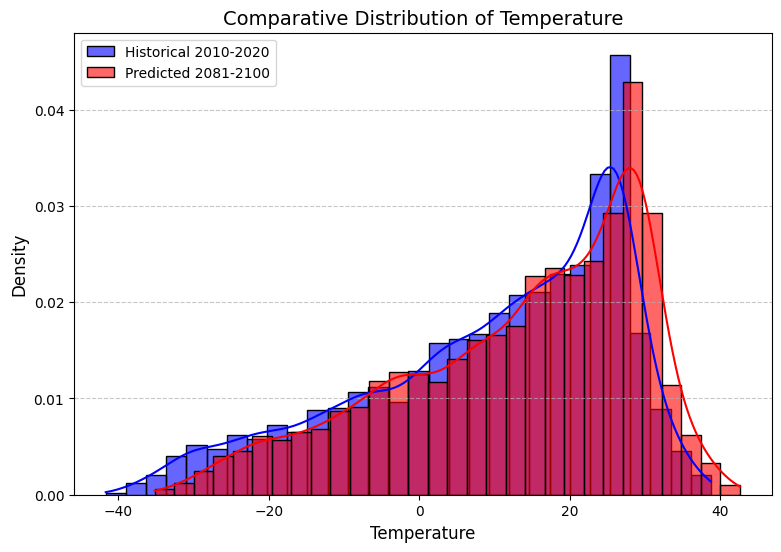

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')  # Mount Google Drive

# Load both CSV files
file1_path = '/content/drive/My Drive/merged_cleaned_10_20.csv'  # Historical
file2_path = '/content/drive/My Drive/merged_cleaned_81_100.csv'  # Predicted

df1 = pd.read_csv(file1_path)
df2 = pd.read_csv(file2_path)

# Standardize column names (lowercase for consistency)
df1.columns = df1.columns.str.lower()
df2.columns = df2.columns.str.lower()

# Identify column groups based on standardized naming conventions
wd_cols = [col for col in df1.columns if col.startswith("wd_")]

# Handle precipitation: Match lowercase column names from both files
precip_cols_1 = [col for col in df1.columns if col.startswith("precipitation_")]
precip_cols_2 = [col for col in df2.columns if col.startswith("precipitation_")]

# Handle temperature: Account for differences in underscores
temp_cols_1 = [col for col in df1.columns if col.startswith("temperature")]
temp_cols_2 = [col for col in df2.columns if col.startswith("temperature_")]

def plot_comparative_distribution(df1, df2, cols1, cols2, var_label, sample_size=10000, kde=True, bins=30):
    """
    Aggregates values from multiple columns in two datasets and plots their comparative distribution.

    Parameters:
        df1, df2 (DataFrame): DataFrames from two CSV files.
        cols1, cols2 (list): Column names to aggregate (one for each file).
        var_label (str): Label for the variable (used for plot titles and labels).
        sample_size (int): Max data points to plot per dataset.
        kde (bool): Whether to overlay a kernel density estimate.
        bins (int): Number of bins for histograms.
    """
    # Validate if columns exist in both dataframes
    if not cols1 or not cols2:
        print(f"No matching columns found for {var_label} in one or both files. Skipping plot.")
        return

    # Aggregate and drop missing values
    agg_series1 = pd.concat([df1[col] for col in cols1], ignore_index=True).dropna()
    agg_series2 = pd.concat([df2[col] for col in cols2], ignore_index=True).dropna()

    # Sample data if too large
    if sample_size:
        agg_series1 = agg_series1.sample(min(sample_size, len(agg_series1)), random_state=42)
        agg_series2 = agg_series2.sample(min(sample_size, len(agg_series2)), random_state=42)

    # Plot comparative distributions (DENSITY instead of Frequency)
    plt.figure(figsize=(9, 6))
    sns.histplot(agg_series1, kde=kde, bins=bins, color='blue', alpha=0.6, label="Historical 2010-2020", stat="density")
    sns.histplot(agg_series2, kde=kde, bins=bins, color='red', alpha=0.6, label="Predicted 2081-2100", stat="density")

    # Customization
    plt.title(f'Comparative Distribution of {var_label}', fontsize=14)
    plt.xlabel(var_label, fontsize=12)
    plt.ylabel('Density', fontsize=12)  # Updated Y-axis label
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot
    plt.show()

# Generate comparative visualizations
plot_comparative_distribution(df1, df2, wd_cols, wd_cols, "Water Demand (wd)")
plot_comparative_distribution(df1, df2, precip_cols_1, precip_cols_2, "Precipitation")
plot_comparative_distribution(df1, df2, temp_cols_1, temp_cols_2, "Temperature")

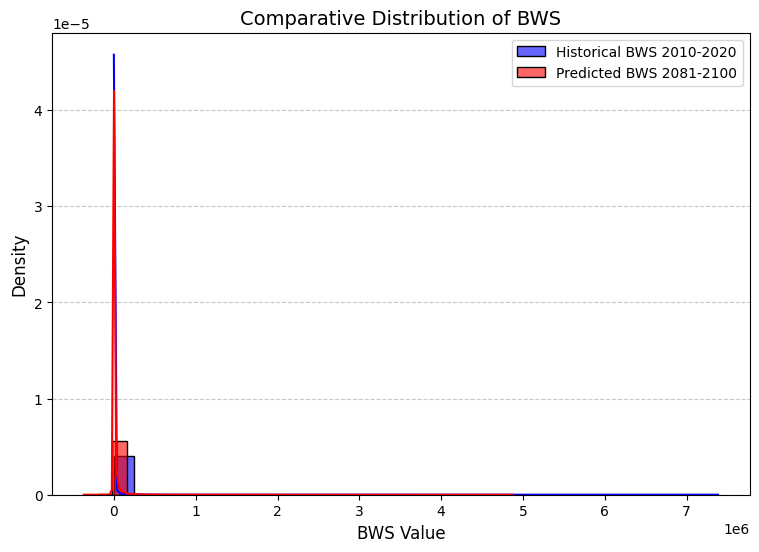

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
actual_file_path = "/content/drive/My Drive/merged_cleaned_10_20.csv"  # Update the path
predicted_file_path = "/content/drive/My Drive/predictions_new_81_100.csv"  # Update the path

df_actual = pd.read_csv(actual_file_path)
df_predicted = pd.read_csv(predicted_file_path)

# Standardize column names
df_actual.columns = df_actual.columns.str.lower()
df_predicted.columns = df_predicted.columns.str.lower()

# Extract BWS values
actual_bws_cols = [col for col in df_actual.columns if col.startswith("bws_")]
predicted_bws_col = "predicted_bws" if "predicted_bws" in df_predicted.columns else None

if actual_bws_cols and predicted_bws_col:
    actual_bws_values = pd.concat([df_actual[col] for col in actual_bws_cols], ignore_index=True).dropna()
    predicted_bws_values = df_predicted[predicted_bws_col].dropna()

    # Plot Distribution (Using Density Instead of Frequency)
    plt.figure(figsize=(9, 6))
    sns.histplot(actual_bws_values, kde=True, bins=30, color='blue', alpha=0.6, label="Historical BWS 2010-2020", stat="density")
    sns.histplot(predicted_bws_values, kde=True, bins=30, color='red', alpha=0.6, label="Predicted BWS 2081-2100", stat="density")

    # Customization
    plt.title("Comparative Distribution of BWS", fontsize=14)
    plt.xlabel("BWS Value", fontsize=12)
    plt.ylabel("Density", fontsize=12)  # Changed from Frequency to Density
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot
    plt.show()
else:
    print("No matching BWS columns found in one or both files. Skipping plot.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


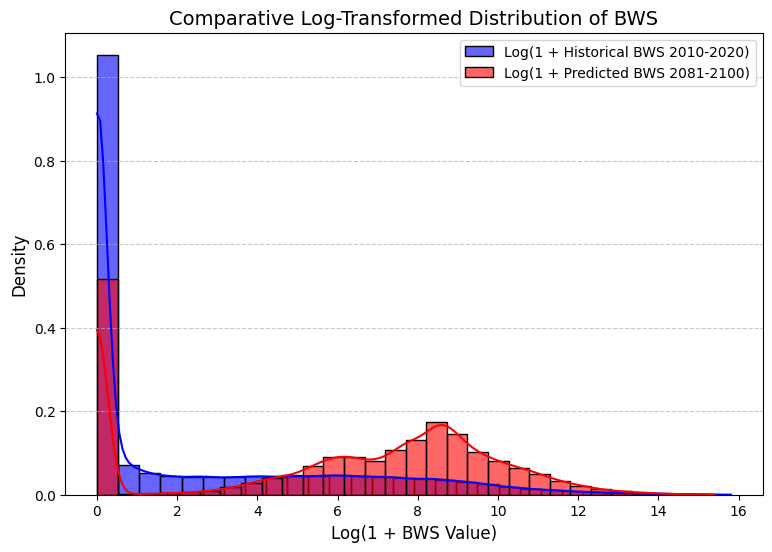

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')  # Mount your Google Drive

# Load the datasets
actual_file_path = "/content/drive/My Drive/merged_cleaned_10_20.csv"  # Update the path
predicted_file_path = "/content/drive/My Drive/predictions_new_81_100.csv"  # Update the path

df_actual = pd.read_csv(actual_file_path)
df_predicted = pd.read_csv(predicted_file_path)

# Standardize column names
df_actual.columns = df_actual.columns.str.lower()
df_predicted.columns = df_predicted.columns.str.lower()

# Extract BWS values
actual_bws_cols = [col for col in df_actual.columns if col.startswith("bws_")]
predicted_bws_col = "predicted_bws" if "predicted_bws" in df_predicted.columns else None

if actual_bws_cols and predicted_bws_col:
    # Combine all actual BWS values and remove NaNs
    actual_bws_values = pd.concat([df_actual[col] for col in actual_bws_cols], ignore_index=True).dropna()
    predicted_bws_values = df_predicted[predicted_bws_col].dropna()

    # Convert negative values to zero
    actual_bws_values = actual_bws_values.clip(lower=0)  # Replaces all negative values with zero
    predicted_bws_values = predicted_bws_values.clip(lower=0)

    # Apply Log Transformation log(1 + BWS)
    log_actual_bws = np.log1p(actual_bws_values)  # Equivalent to log(1 + BWS)
    log_predicted_bws = np.log1p(predicted_bws_values)  # Equivalent to log(1 + BWS)

    # Plot Log-Transformed Distribution
    plt.figure(figsize=(9, 6))
    sns.histplot(log_actual_bws, kde=True, bins=30, color='blue', alpha=0.6, label="Log(1 + Historical BWS 2010-2020)", stat="density")
    sns.histplot(log_predicted_bws, kde=True, bins=30, color='red', alpha=0.6, label="Log(1 + Predicted BWS 2081-2100)", stat="density")

    # Customization
    plt.title("Comparative Log-Transformed Distribution of BWS", fontsize=14)
    plt.xlabel("Log(1 + BWS Value)", fontsize=12)
    plt.ylabel("Density", fontsize=12)  # Kept density scaling
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot
    plt.show()
else:
    print("No matching BWS columns found in one or both files. Skipping plot.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


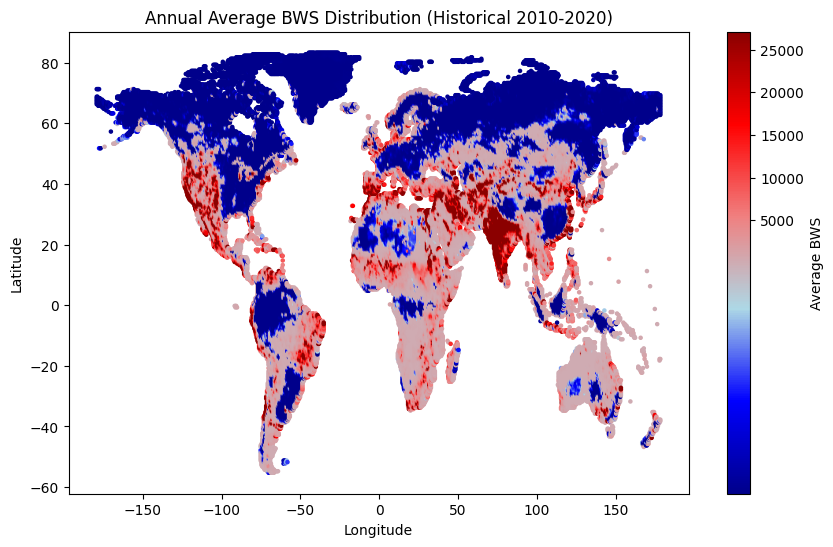

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
from google.colab import drive

# 🔹 Step 1: Mount Google Drive
drive.mount('/content/drive')

# 🔹 Step 2: Load the CSV File from Google Drive
file_path = "/content/drive/My Drive/merged_cleaned_10_20.csv"  # Update with your actual file path
original_df = pd.read_csv(file_path)

# 🔹 Step 3: Standardize Column Names
original_df.columns = original_df.columns.str.lower()

# 🔹 Step 4: Identify BWS Columns & Compute Annual Average BWS
bws_cols = [col for col in original_df.columns if col.startswith("bws_")]
original_df["avg_bws"] = original_df[bws_cols].mean(axis=1)  # Compute the annual average

# 🔹 Step 5: Define a New Colormap (No White)
#    Dark Blue → Blue → Light Blue → Light Red → Red → Dark Red
cmap = colors.LinearSegmentedColormap.from_list(
    "custom_bws",
    [
        "darkblue",   # Very low BWS
        "blue",
        "lightblue",
        "lightcoral",
        "red",
        "darkred"     # Very high BWS
    ]
)

# 🔹 Step 6: Normalize Color Scaling
valid_bws = original_df["avg_bws"].dropna()
if valid_bws.empty:
    print("⚠️ No valid BWS values found. Check your data.")
else:
    vmin = np.percentile(valid_bws, 5)   # 5th percentile
    vmax = np.percentile(valid_bws, 95)  # 95th percentile
    vcenter = np.median(valid_bws)       # Use median as center

    # Ensure vmin < vcenter < vmax for smooth transitions
    if vmin >= vcenter:
        vcenter = (vmin + vmax) / 2

    norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

    # 🔹 Step 7: Create the Heatmap (Scatter Plot)
    plt.figure(figsize=(10, 6))
    sc = plt.scatter(
        original_df['lon'], original_df['lat'],
        c=original_df['avg_bws'], cmap=cmap, norm=norm, s=5
    )

    # 🔹 Step 8: Add Colorbar
    plt.colorbar(sc, label='Average BWS')

    # 🔹 Step 9: Labels & Title
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Annual Average BWS Distribution (Historical 2010-2020)")

    # 🔹 Step 10: Show the Plot
    plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ All required columns are present.


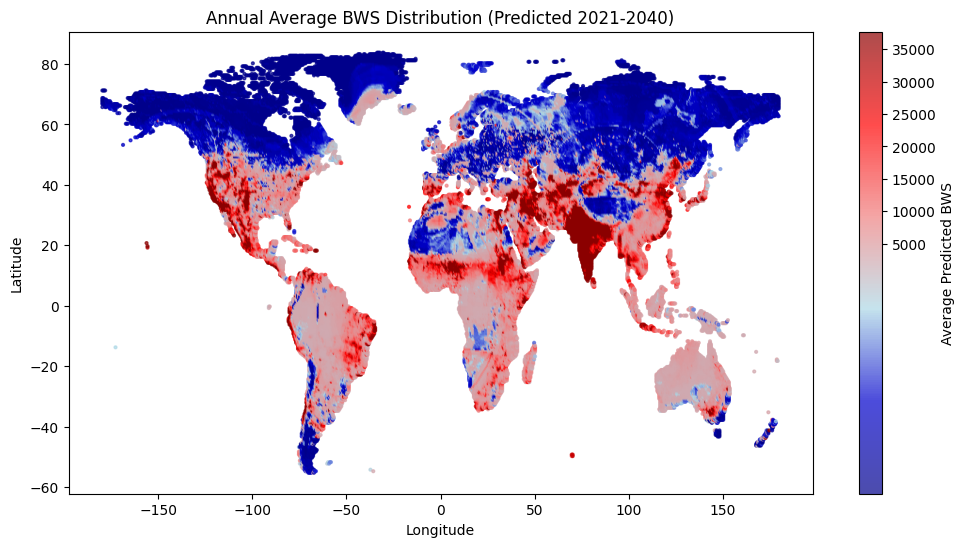

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
from google.colab import drive

# 🔹 Step 1: Mount Google Drive
drive.mount('/content/drive')

# 🔹 Step 2: Load the CSV File from Google Drive
file_path = "/content/drive/My Drive/predictions_new_21_40.csv"  # Update with your actual file path
df = pd.read_csv(file_path)

# 🔹 Step 3: Standardize Column Names
df.columns = df.columns.str.lower()  # Ensure lowercase column names

# 🔹 Step 4: Check if the Required Columns Exist
required_columns = {"lon", "lat", "predicted_bws"}
if not required_columns.issubset(df.columns):
    print(f"⚠️ Missing required columns! Found: {df.columns.tolist()}")
else:
    print("✅ All required columns are present.")

    # 🔹 Step 5: Convert Negative BWS Values to Zero
    df["predicted_bws"] = df["predicted_bws"].apply(lambda x: max(x, 0))  # Set negatives to zero

    # 🔹 Step 6: **Round Coordinates to Avoid Slight Offset Issues**
    df["lon"] = df["lon"].round(2)  # Round to 2 decimal places
    df["lat"] = df["lat"].round(2)  # Adjust based on dataset precision

    # 🔹 Step 7: Compute **Average BWS per Coordinate (Across 12 Months)**
    df_avg = df.groupby(["lon", "lat"], as_index=False)["predicted_bws"].mean()

    # 🔹 Step 8: Define Colormap (No White, Only Blue → Red)
    cmap = colors.LinearSegmentedColormap.from_list(
        "custom_bws",
        [
            "darkblue",   # Very low BWS
            "mediumblue",
            "lightblue",
            "lightcoral",
            "red",
            "darkred"     # Very high BWS
        ]
    )

    # 🔹 Step 9: Normalize Color Scaling (Handle NaN Cases)
    valid_bws = df_avg["predicted_bws"].dropna()
    if valid_bws.empty:
        print("⚠️ No valid BWS values found for plotting. Skipping heatmap.")
    else:
        vmin = np.percentile(valid_bws, 5)  # 5th percentile
        vmax = np.percentile(valid_bws, 95)  # 95th percentile
        vcenter = np.median(valid_bws)  # Use median as center

        # Ensure vmin < vcenter < vmax for smooth transitions
        if vmin >= vcenter:
            vcenter = (vmin + vmax) / 2

        norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

        # 🔹 Step 10: Create the Heatmap (Scatter Plot)
        plt.figure(figsize=(12, 6))
        sc = plt.scatter(
            df_avg['lon'], df_avg['lat'],
            c=df_avg['predicted_bws'], cmap=cmap, norm=norm, s=4, alpha=0.7  # Adjusted for clarity
        )

        # 🔹 Step 11: Add Colorbar
        plt.colorbar(sc, label='Average Predicted BWS')

        # 🔹 Step 12: Labels & Title
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.title("Annual Average BWS Distribution (Predicted 2021-2040)")

        # 🔹 Step 13: Show the Plot
        plt.show()